# Traffic Sign Classification

**Table of Contents:**

- Introduction
- Import and preprocess the images
- Building and training the CNN
- Prediction on test set
- Saliency maps

## Introduction

In this project I am going to perform a computer vision task. More specifically, I am going to predict the class of traffic signs with a convolutional neural network. 

Normally, such a task would consist of two components. First, the traffic sign should be recognized from the picture. Second, the traffic sign should be classified into one of the many categories. I will focus on the second task.

For this I use a dataset that consists of many traffic signs. You can find the data [here](https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign). 

In [1]:
import os
os.chdir("D:/Projects/German Traffic Signs/Archive")

In [2]:
# import dependencies
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
%matplotlib inline

## Import and preprocess the images

In [3]:
# create some of the variables
train_path = "./Train"
NUM_CATEGORIES = len(os.listdir(train_path))
height = 30
width = 30
data = []
labels = []

We are going to populate the data list with the images. Each category has a folder where the images are located in. These images will be opened, and then resized to a height of 30 and a width of 30. Then these images will be put into the data list and the corresponding category numbers will be put into the labels list.

In [4]:
# populate the data list with resized images
for i in range(NUM_CATEGORIES):
    path = os.path.join(train_path, f"{i}")
    images = os.listdir(path)
    
    for image in images:
        image = Image.open(path + "/" + image)
        image = image.resize((height,width))
        image = np.array(image)
        data.append(image)
        labels.append(i)

In [5]:
# create numpy arrays
data = np.array(data)      
labels = np.array(labels) 

To see what the categories are, I am going to plot the first image for each of the categories:

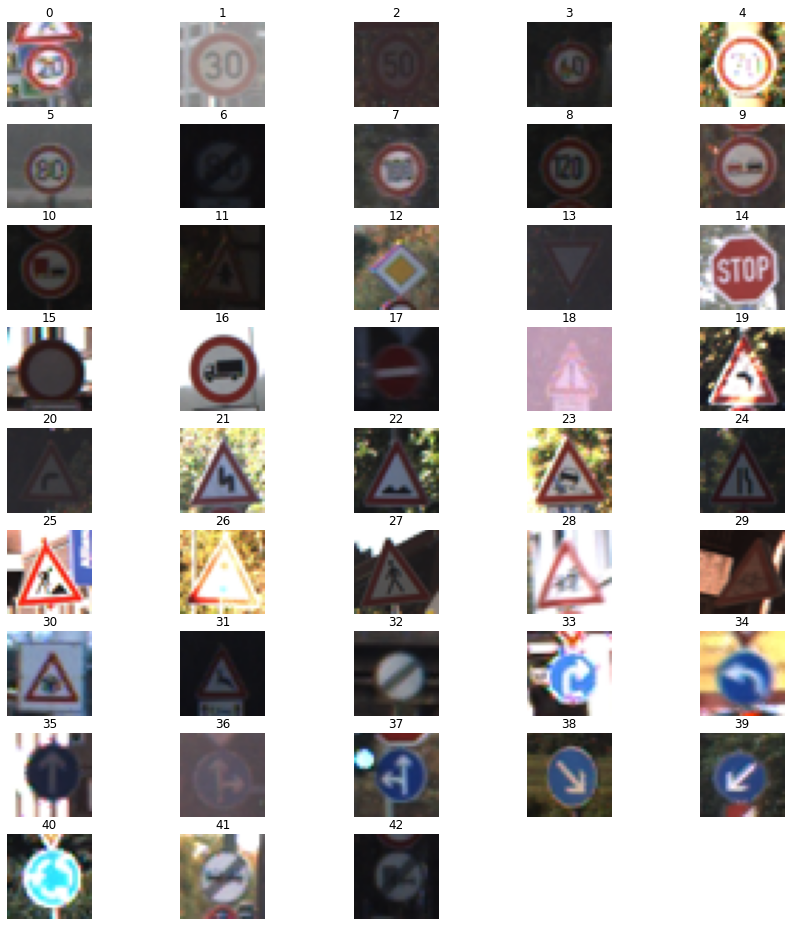

In [6]:
# show the first image for each category
ixs = [np.where(labels==i)[0][i] for i in range(NUM_CATEGORIES)]

fig = plt.figure(constrained_layout=False, figsize=(15,15))
gs = fig.add_gridspec(9,5, top=0.93, bottom=0.1)

column = 0
row = 0

def counter(i_1, column, row):
    if i_1 % 5 == 0:
        column += 1
        row = 0
    else:
        row += 1
    return column, row

for i, ix in zip(range(NUM_CATEGORIES), ixs):
    i_1 = i + 1
    ax = fig.add_subplot(gs[column, row])
    ax.imshow(data[ix])
    ax.set_title(f"{i}")
    plt.axis("off")
    column, row = counter(i_1, column, row)



As you can see, these images contain traffic signs for each of the categories. The images are all of equal size. Sometimes they are not very clear, and sometimes there may be parts of other traffic signs in the image.

Now, let's create a training set and a validation set.

In [7]:
# create training and validation set
X_train, X_val, Y_train, Y_val = train_test_split(data,labels,test_size=0.2,random_state=42, shuffle=True)

As the neural net works best for inputs that have values between 0 and 1, we divide the values by their maximum value.

In [8]:
# preprocess input
X_train = X_train/255 
X_val = X_val/255

print("X_train.shape:",X_train.shape)
print("X_val.shape:", X_val.shape)

X_train.shape: (31367, 30, 30, 3)
X_val.shape: (7842, 30, 30, 3)


The training set has 31367 samples, and the validation set has 7842 samples. The images themselves are 30 (height) by 30 (width). And there are 3 color channels (red, green and blue).

Let's also preprocess the target variable so that it can be used in the neural network.

In [9]:
# preprocess output
Y_train=keras.utils.to_categorical(Y_train,NUM_CATEGORIES)
Y_val= keras.utils.to_categorical(Y_val,NUM_CATEGORIES)

print(Y_train.shape)
print(Y_val.shape)

(31367, 43)
(7842, 43)


## Building and training the CNN

In this section I am going to build and fit the model. The first layers of the model are the convolutional layers. The latter layers are dense layers. Note that in the dense layers I use a single dropout layer for regulatarizaton purposes. The final layer is a softmax layer. Let's build the model! 

In [10]:
# Building the model using the functional API
inputlayer = keras.layers.Input(shape=(height, width, 3))
conv2d_1 = keras.layers.Conv2D(filters=30, kernel_size=(3,3), activation="relu")(inputlayer)
conv2d_2 = keras.layers.Conv2D(filters=30, kernel_size=(3,3), activation="relu")(conv2d_1)
maxpool2d_1 = keras.layers.MaxPool2D(pool_size=(2,2))(conv2d_2)
conv2d_3 = keras.layers.Conv2D(filters=60, kernel_size=(3,3), activation="relu")(maxpool2d_1)
conv2d_4 = keras.layers.Conv2D(filters=60, kernel_size=(3,3), activation="relu")(conv2d_3)
maxpool2d_2 = keras.layers.MaxPool2D(pool_size=(2,2))(conv2d_4)
flatten = keras.layers.Flatten()(maxpool2d_2)
dense_1 = keras.layers.Dense(500, activation="relu")(flatten)
dropout = keras.layers.Dropout(0.5)(dense_1)
dense_2 = keras.layers.Dense(NUM_CATEGORIES)(dropout)
activation = keras.layers.Activation("softmax")(dense_2)

model = keras.models.Model(inputs=inputlayer, outputs=activation)

In [11]:
# summary of the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 30, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 30)        840       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 30)        8130      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 30)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 60)        16260     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 60)          32460     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 60)          0     

In [12]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Now that we have build the model, let's fit the model. I will use the early stopping in order to make sure that the model doesn't run needlessly for too long. Let's fit the model!

In [13]:
batch_size = 35
epochs = 20

early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", min_delta=0.001, patience=5, restore_best_weights=True)

history = model.fit(X_train,Y_train,batch_size=batch_size,
                    epochs=epochs, validation_data=(X_val, Y_val),
                    callbacks=[early_stopping_cb]
                   )

Epoch 1/20
897/897 [==============================] - 30s 34ms/step - loss: 0.8762 - accuracy: 0.7511 - val_loss: 0.1137 - val_accuracy: 0.9745
Epoch 2/20
897/897 [==============================] - 31s 34ms/step - loss: 0.1109 - accuracy: 0.9672 - val_loss: 0.0471 - val_accuracy: 0.9881
Epoch 3/20
897/897 [==============================] - 30s 34ms/step - loss: 0.0649 - accuracy: 0.9803 - val_loss: 0.0356 - val_accuracy: 0.9911
Epoch 4/20
897/897 [==============================] - 31s 34ms/step - loss: 0.0473 - accuracy: 0.9858 - val_loss: 0.0268 - val_accuracy: 0.9935
Epoch 5/20
897/897 [==============================] - 30s 34ms/step - loss: 0.0360 - accuracy: 0.9894 - val_loss: 0.0384 - val_accuracy: 0.9902
Epoch 6/20
897/897 [==============================] - 30s 34ms/step - loss: 0.0339 - accuracy: 0.9889 - val_loss: 0.0348 - val_accuracy: 0.9903
Epoch 7/20
897/897 [==============================] - 31s 34ms/step - loss: 0.0236 - accuracy: 0.9923 - val_loss: 0.0270 - val_accuracy:

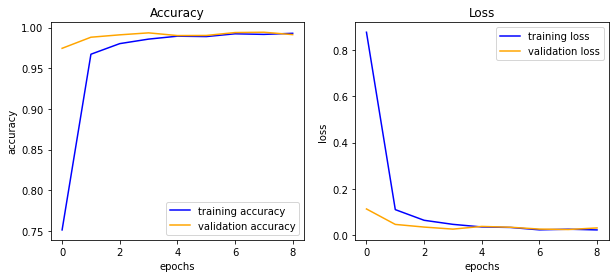

In [14]:
# plotting learning curves

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(history.history["accuracy"], label="training accuracy", color="blue")
ax1.plot(history.history["val_accuracy"], label="validation accuracy", color="orange")
ax1.set_title("Accuracy")
ax1.set_xlabel("epochs")
ax1.set_ylabel("accuracy")
ax1.legend()

ax2 = fig.add_subplot(1,2,2)
ax2.plot(history.history["loss"], label="training loss", color="blue")
ax2.plot(history.history["val_loss"], label="validation loss", color="orange")
ax2.set_title("Loss")
ax2.set_xlabel("epochs")
ax2.set_ylabel("loss")
ax2.legend()

As can be seen, the test accuracy is already very high in the earlier epochs. The training accuracy is lower than the validation accuracy, which may be weird. However, this is due to the dropout layer, where a lot of neurons are not used for training, which results in a lower training accuracy. For the validation set, all neurons are used.

## Prediction on test set

Now let's see how the model performs with unseen test data.

In [15]:
test = pd.read_csv("test.csv")

In [16]:
test.head(10)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png
5,52,56,5,5,47,51,38,Test/00005.png
6,147,130,12,12,135,119,18,Test/00006.png
7,32,33,5,5,26,28,12,Test/00007.png
8,45,50,6,5,40,45,25,Test/00008.png
9,81,86,7,7,74,79,35,Test/00009.png


In [17]:
# populate the data_test list with resized images
labels_test = test["ClassId"].values
paths = test["Path"].values

data_test = []

for path in paths:
    image = Image.open(path)
    image = image.resize((height,width))
    image = np.array(image)
    data_test.append(image)

In [18]:
# preprocess the data_test input
data_test = np.array(data_test)
data_test = data_test / 255
print(data_test.shape)

(12630, 30, 30, 3)


In [19]:
# make predictons for the test data
predict_probas = model.predict(data_test)
predictions = np.argmax(predict_probas, axis=1)
predictions

array([16,  1, 38, ...,  5,  7, 10], dtype=int64)

In [20]:
accuracy = accuracy_score(labels_test, predictions)
print(accuracy)

0.9642121931908155


So the accuracy of this model on the test set is around 96.8 percent, which is a pretty good performance. However, the model is seems to overfit a bit, as the accuracy on the test set is lower then on the validation set. For future models we could use some alternative regularization methods, such as the inclusion of more dropout layers, or data augmentation.

## Saliency maps

In this section I create some saliency maps. Saliency maps provide insight into how the neural network reaches a prediction. In other words, what elements of the image does the network focus on? These pixels in the saliency map should be brighter. For more on how to do this with Keras see [here](https://stackoverflow.com/questions/63107141/how-to-compute-saliency-map-using-keras-backend).

Saliency maps are especcially useful if there is doubt that a prediction is reached based on the right features. For instance, if there are always trees on images of birds, then the tree might cause the prediction, which is not what we want. For our purposes, saliency maps might not be necessary as the trafic sign captures most of the image. However, we are going to create them to see whether the network focuses on the right stuff. 

My expectation is that the network will focus on the complete traffic sign. Of course, within the traffic sign there might be some variation in brightness. Sometimes an image shows (part of) another sign: this part of the image should of course not be taken into account while predicting the class.

In [21]:
# define model, excluding the last layer
linear_model = keras.Model(inputs=inputlayer, outputs=model.layers[-2].output)

In [22]:
# define function that generates a saliency map
def get_saliency_map(model, image, class_idx):
    with tf.GradientTape() as tape:
        tape.watch(image)
        predictions = model(image)
        
        loss = predictions[:, class_idx]
        
    gradient = tape.gradient(loss, image)
    
    gradient = tf.reduce_max(gradient, axis=-1)
    
    gradient = gradient.numpy()
    
    min_val, max_val = np.min(gradient), np.max(gradient)
    smap = (gradient - min_val) / ( max_val - min_val + keras.backend.epsilon())
    
    return smap

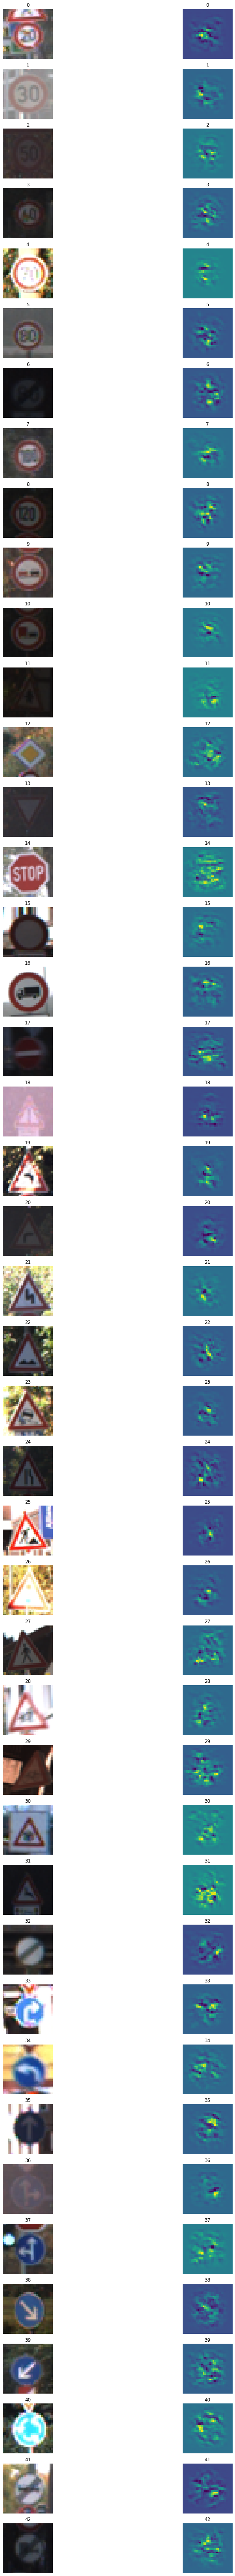

In [23]:
# show the images and the saliency maps for the first image for each category in the dataset.
ixs = [np.where(labels==i)[0][i] for i in range(NUM_CATEGORIES)]

fig = plt.figure(figsize=(15,120))

for i, ix in zip(range(NUM_CATEGORIES), ixs):
    if i == 0:
        position = 1
    else:
        position += 1
    ax = fig.add_subplot(NUM_CATEGORIES, 2, position)
    ax.imshow(data[ix])
    ax.set_title(f"{i}")
    plt.axis("off")
    position += 1
    ax = fig.add_subplot(NUM_CATEGORIES, 2, position)
    input_image = data[ix]
    pred = np.argmax(model.predict(np.expand_dims(input_image, axis=0)))
    saliency_map = get_saliency_map(linear_model, tf.convert_to_tensor([data[ix]], dtype=tf.float32), pred)
    ax.imshow(saliency_map[0])
    ax.set_title(f"{i}")
    plt.axis("off")

From the figures above you can see that the borders and the corners of the saliency maps are always of neutral color, hence what's in the middle of the image is most relevant in predicting the category. Sometimes there are parts of other traffic signs on the image, such as in the first image, or in the images 39 till 42. As can be seen, these other signs do not turn up brighter in the saliency maps, which indicates that the relevant traffic sign is being picked up.